In [1]:
import os, re, configparser, math
import pandas as pd
import numpy as np
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table, show_table
from utilities_plotting import plot_scatter
from utilities_widgets import position_chart
from utilities_IO import output_html
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
import matplotlib.pyplot as plt
from statistics import mean
import pdfkit

Database *input.db* found in: c:\Codebase\Python_Eiit_RyR\a6_Variability_Study\database\input.db
Database *output.db* found in: c:\Codebase\Python_Eiit_RyR\a6_Variability_Study\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
try: #Tries to find a table for the fixture data
    fixture_data = consult_database("input.db", verbose=False, filter="_FixtureData_")[-1]
    file = '_'.join(fixture_data.split("_")[:-7])
except: #Resorts to using globals values
    raise TypeError("Incorrect fixture data.")
try: #Tries to search for the last tables related to the fixture data
    default_measurements = consult_database("input.db", verbose=False, filter=file+"_Measurements_")[-1]
    default_limits = consult_database("input.db", verbose=False, filter=file+"_Limits_")[-1]
except Exception as e:
    raise Exception("Missing the required tables. Ensure you have the required tables.")
try: #Tries to find a table for the fixture data to compose
    value=(default_measurements, default_limits, fixture_data)
except:
    value=(default_measurements, default_limits)
tables = widgets.SelectMultiple(options=table_list, value=value, description='input db', rows=10, layout={'width': '600px'})

In [3]:
##Database management
print(f"File(s) ready to use:")
for table in tables.value:
    print(f"    {table}")

File(s) ready to use:
    T_CROSS_Parte2_Measurements_2024y_05m_16d_8h_17m_45s
    T_CROSS_Parte2_Limits_2024y_05m_16d_8h_17m_45s
    T_CROSS_Parte2_FixtureData_2024y_05m_16d_11h_39m_41s


In [4]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "Measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "Limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "FixtureData" in string), None), index_col="index")
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1, 0), layout=Layout(width='600px'), options=('T_CROSS_Parte2…

Table *T_CROSS_Parte2_Measurements_2024y_05m_16d_8h_17m_45s* retrieved succesfully.
Table *T_CROSS_Parte2_Limits_2024y_05m_16d_8h_17m_45s* retrieved succesfully.
Table *T_CROSS_Parte2_FixtureData_2024y_05m_16d_11h_39m_41s* retrieved succesfully.


# Plot and trends

,Angulo de pendiente
Guia_Luz_Blanco_FB1_X,0.000038
Guia_Luz_Blanco_FB1_Y,0.000008
Guia_Luz_Blanco_FB2_X,0.000024
Guia_Luz_Blanco_FB2_Y,-0.000003
Guia_Luz_Blanco_FB3_X,-0.000050
Guia_Luz_Blanco_FB3_Y,-0.000050
Guia_Luz_Blanco_FB4_X,0.000026
Guia_Luz_Blanco_FB4_Y,0.000014
Guia_Luz_Blanco_FB5_X,0.000020
Guia_Luz_Blanco_FB5_Y,0.000004


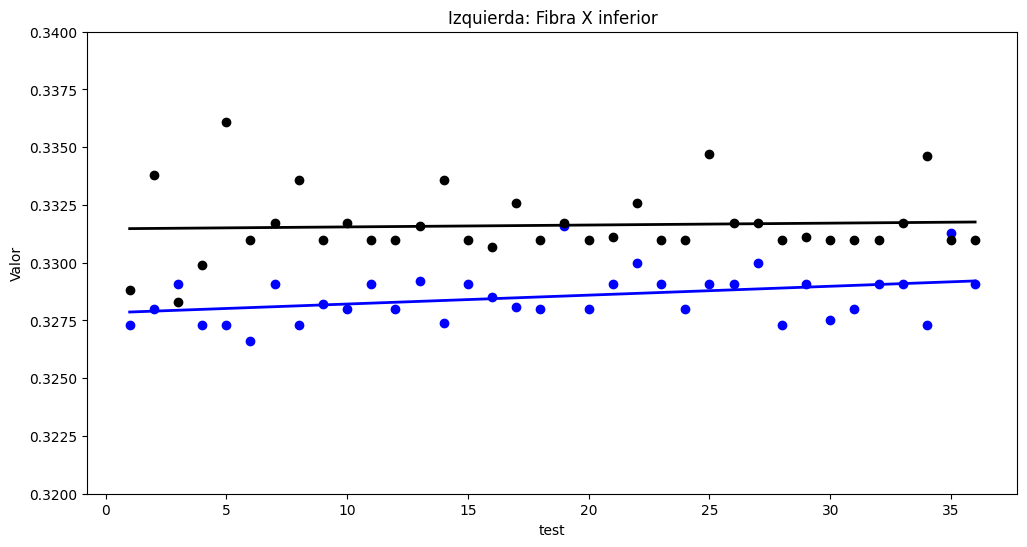

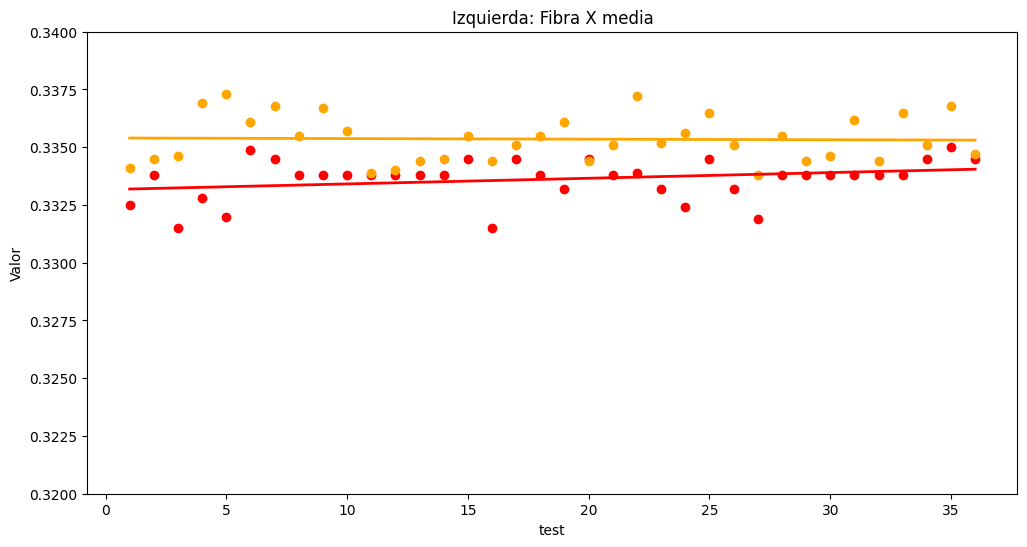

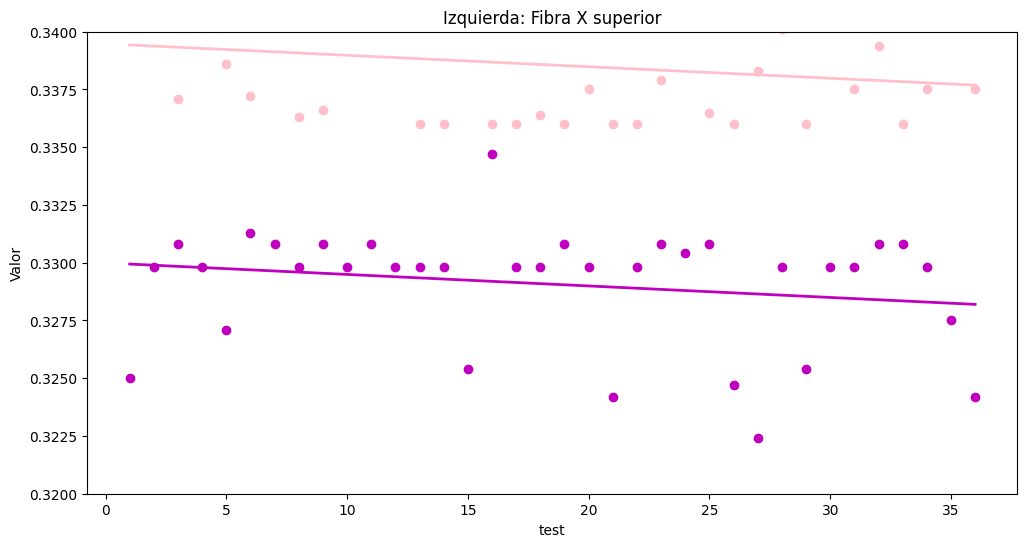

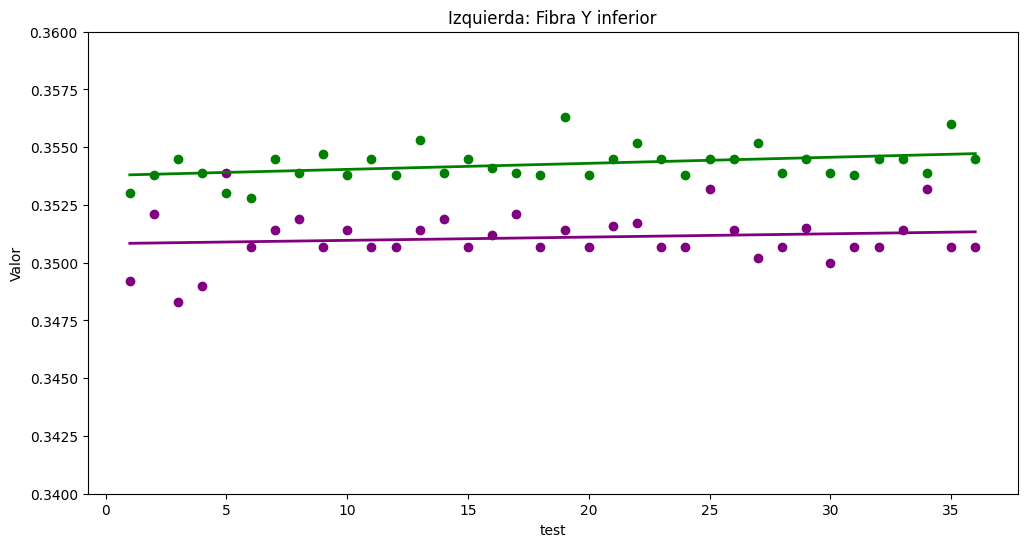

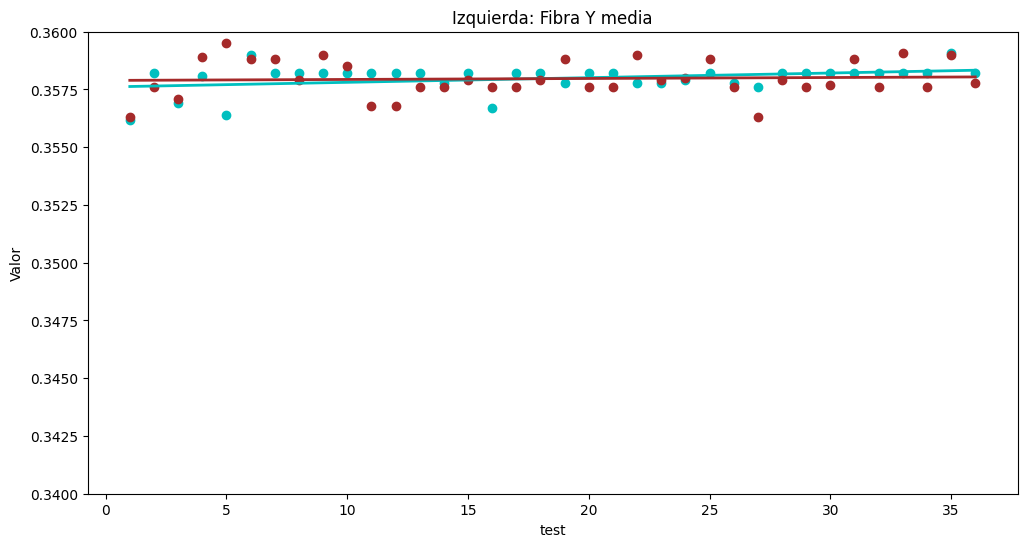

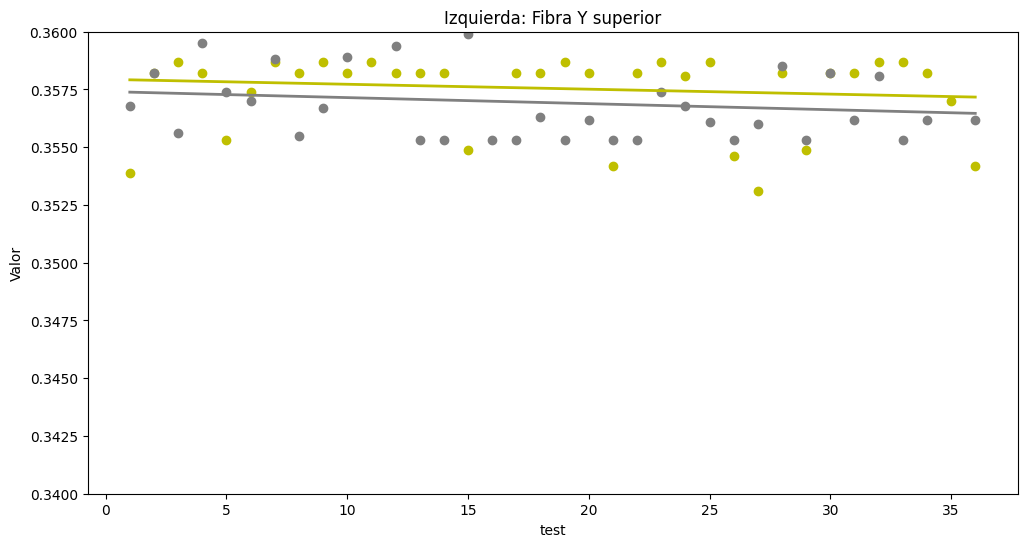

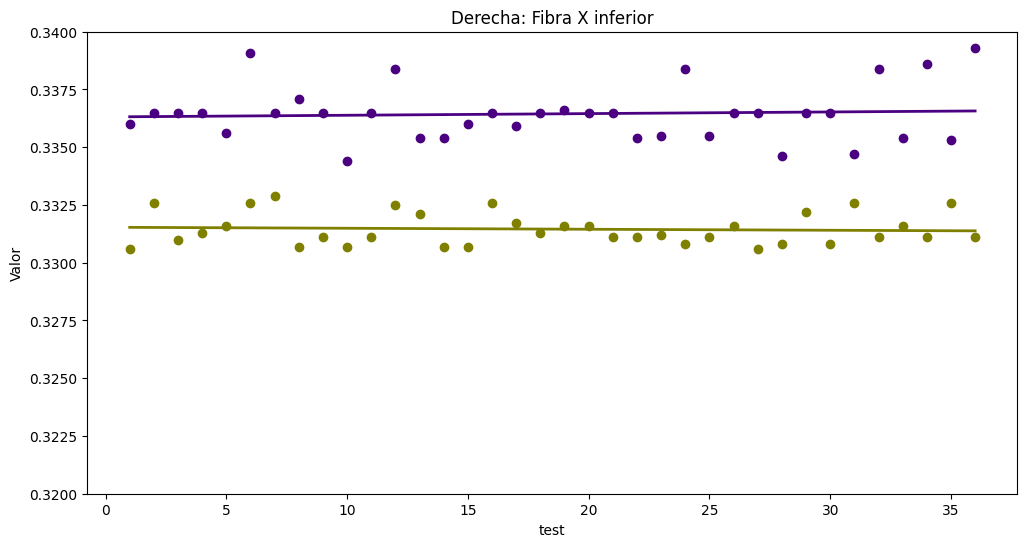

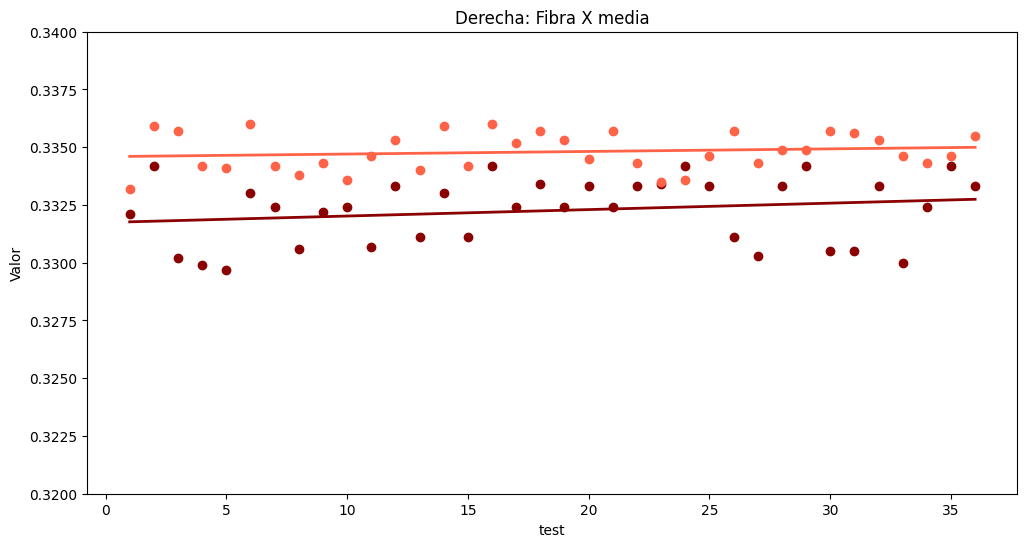

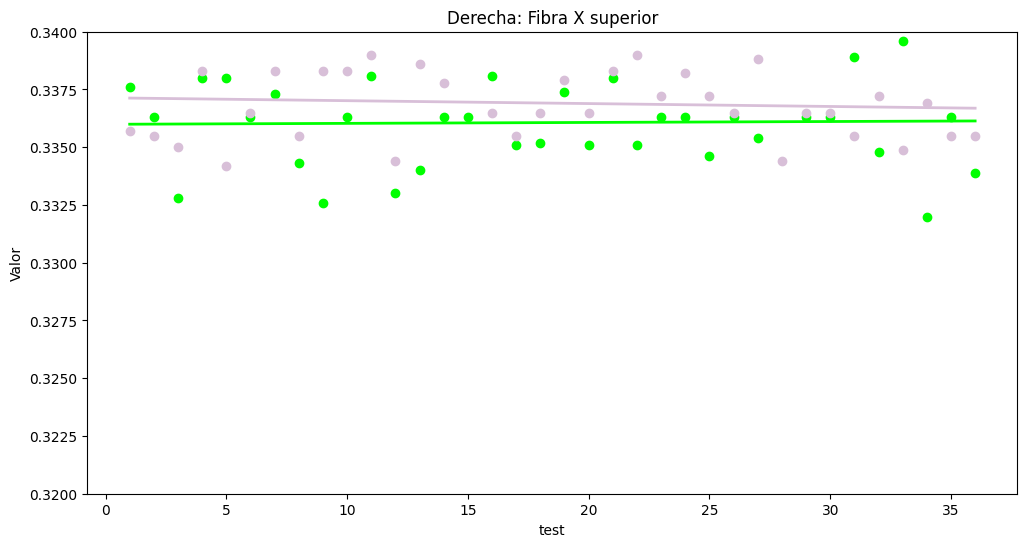

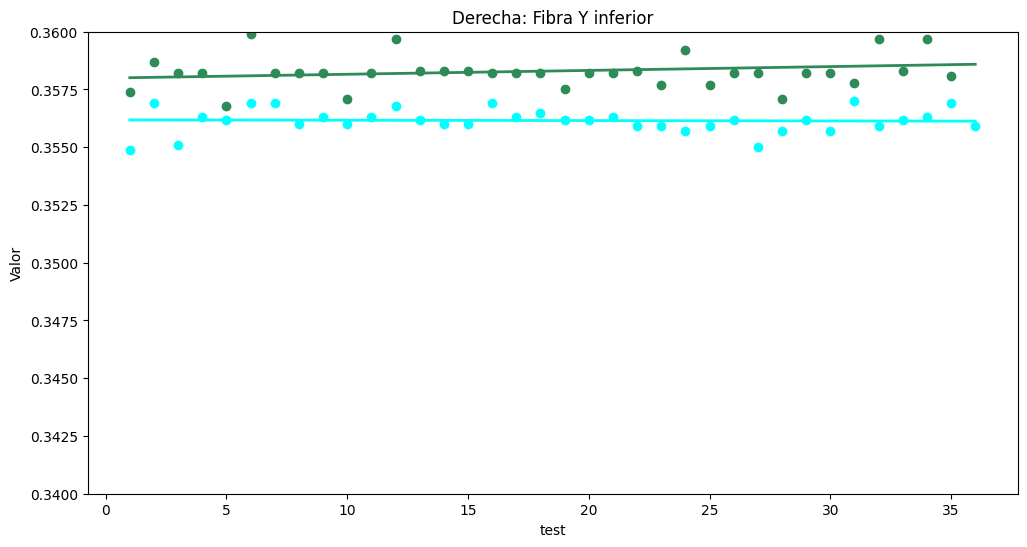

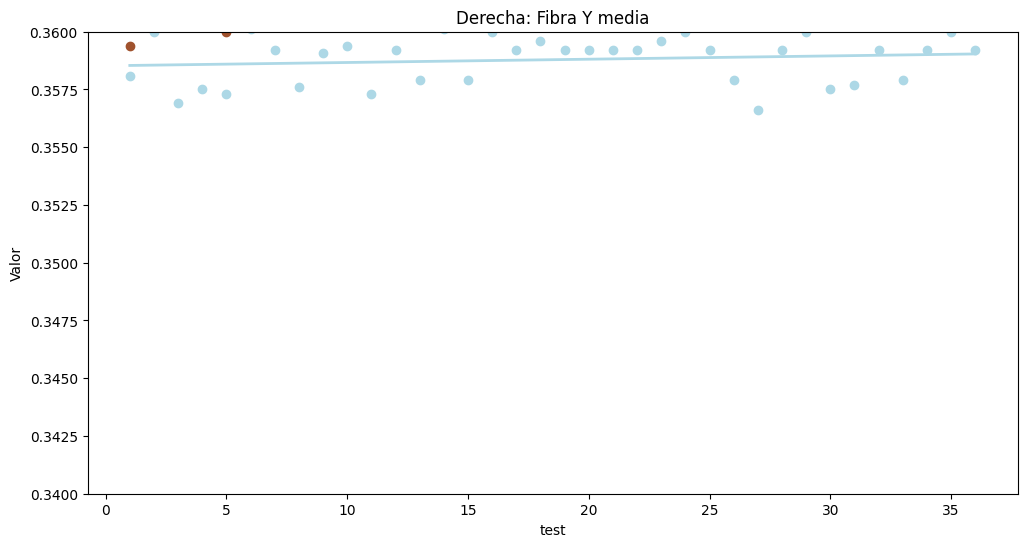

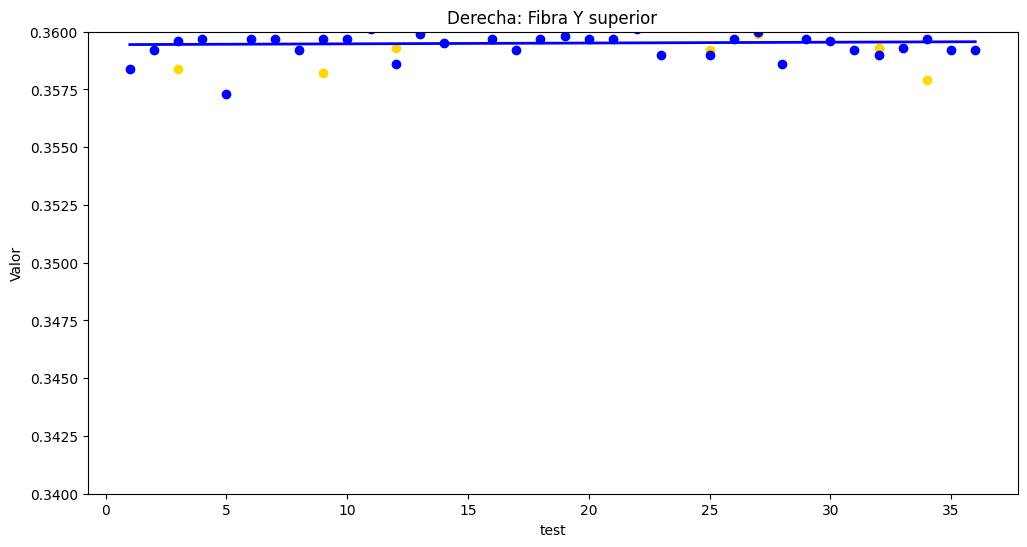

In [5]:
fibers = MEAS.to_numpy()
titles = ["Izquierda: Fibra X inferior", "Izquierda: Fibra X media", "Izquierda: Fibra X superior", "Izquierda: Fibra Y inferior", "Izquierda: Fibra Y media", "Izquierda: Fibra Y superior", 
          "Derecha: Fibra X inferior", "Derecha: Fibra X media", "Derecha: Fibra X superior", "Derecha: Fibra Y inferior", "Derecha: Fibra Y media", "Derecha: Fibra Y superior"]
yrange = [[0.32, 0.34], [0.32, 0.34], [0.32, 0.34], [0.34, 0.36], [0.34, 0.36], [0.34, 0.36],
         [0.32, 0.34], [0.32, 0.34], [0.32, 0.34], [0.34, 0.36], [0.34, 0.36], [0.34, 0.36]]
filter = [[1, 7], [3, 9], [5, 11], [2, 8], [4, 10], [6, 12], [13, 19], [15, 21], [17, 23], [14, 20], [16, 22], [18, 24]]
slopes_list = []
for i in range(int(fibers.shape[0]/2)):
    fig, slopes = plot_scatter(MEAS, title=titles[i], xlabel='test', ylabel='Valor', filter=filter[i], yrange=yrange[i], add_tendency=True) 
    #fig.savefig(f'visualization{i}.png')
    slopes_list.append([round(math.atan(m), 12) for m in slopes][0])
    slopes_list.append([round(math.atan(m), 12) for m in slopes][1])    
slopes_list = pd.DataFrame(slopes_list, columns=["Angulo de pendiente"])
slopes_list = rename_index(slopes_list)
display(slopes_list)

In [15]:
fiber_1x = fibers[0]
fiber_1y = fibers[1]
fiber_2x = fibers[2] 
fiber_2y = fibers[3]
fiber_3x = fibers[4]
fiber_3y = fibers[5]
fiber_4x = fibers[6]
fiber_4y = fibers[7]
fiber_5x = fibers[8]
fiber_5y = fibers[9]
fiber_6x = fibers[10]
fiber_6y = fibers[11]
fiber_7x = fibers[12]
fiber_7y = fibers[13]
fiber_8x = fibers[14]
fiber_8y = fibers[15]
fiber_9x = fibers[16]
fiber_9y = fibers[17]
fiber_10x = fibers[18]
fiber_10y = fibers[19]
fiber_11x = fibers[20]
fiber_11y = fibers[21]
fiber_12x = fibers[22]
fiber_12y = fibers[23]
differences_list = [
np.round(np.mean(np.absolute(fiber_1x - fiber_4x)), 4),
np.round(np.mean(np.absolute(fiber_2x - fiber_5x)), 4),
np.round(np.mean(np.absolute(fiber_3x - fiber_6x)), 4),
np.round(np.mean(np.absolute(fiber_1y - fiber_4y)), 4),
np.round(np.mean(np.absolute(fiber_2y - fiber_5y)), 4),
np.round(np.mean(np.absolute(fiber_3y - fiber_6y)), 4),
np.round(np.mean(np.absolute(fiber_7x - fiber_10x)), 4),
np.round(np.mean(np.absolute(fiber_8x - fiber_11x)), 4),
np.round(np.mean(np.absolute(fiber_9x - fiber_12x)), 4),
np.round(np.mean(np.absolute(fiber_7y - fiber_10y)), 4),
np.round(np.mean(np.absolute(fiber_8y - fiber_11y)), 4),
np.round(np.mean(np.absolute(fiber_9y - fiber_12y)), 4)
]
rel_difference_list = [
    round(differences_list[0]/mean(fiber_1x + fiber_4x), 4),
    round(differences_list[1]/mean(fiber_2x + fiber_5x), 4),
    round(differences_list[2]/mean(fiber_3x + fiber_6x), 4),
    round(differences_list[3]/mean(fiber_1y + fiber_4y), 4),
    round(differences_list[4]/mean(fiber_2y + fiber_5y), 4),
    round(differences_list[5]/mean(fiber_3y + fiber_6y), 4),
    round(differences_list[6]/mean(fiber_7x + fiber_10x), 4),
    round(differences_list[7]/mean(fiber_8x + fiber_11x), 4),
    round(differences_list[8]/mean(fiber_9x + fiber_12x), 4),
    round(differences_list[9]/mean(fiber_7y + fiber_10y), 4),
    round(differences_list[10]/mean(fiber_8y + fiber_11y), 4),
    round(differences_list[11]/mean(fiber_9y + fiber_12y), 4)
]

diffs = pd.DataFrame([differences_list, rel_difference_list]).transpose()
diffs.index = titles
diffs.columns = ["Diferencias absolutas entre nidos", "Diferencias relativas entre nidos"]
display(diffs)

,Diferencias absolutas entre nidos,Diferencias relativas entre nidos
Izquierda: Fibra X inferior,0.0019,0.0029
Izquierda: Fibra X media,0.0021,0.0032
Izquierda: Fibra X superior,0.0117,0.0177
Izquierda: Fibra Y inferior,0.0053,0.0076
Izquierda: Fibra Y media,0.0034,0.0048
Izquierda: Fibra Y superior,0.0005,0.0007
Derecha: Fibra X inferior,0.0046,0.0070
Derecha: Fibra X media,0.0002,0.0003
Derecha: Fibra X superior,0.0029,0.0043
Derecha: Fibra Y inferior,0.0015,0.0021


# Bland-Altman Plot

References:
https://www.researchgate.net/publication/318482587_Decoding_the_Bland-Altman_plot_Basic_review

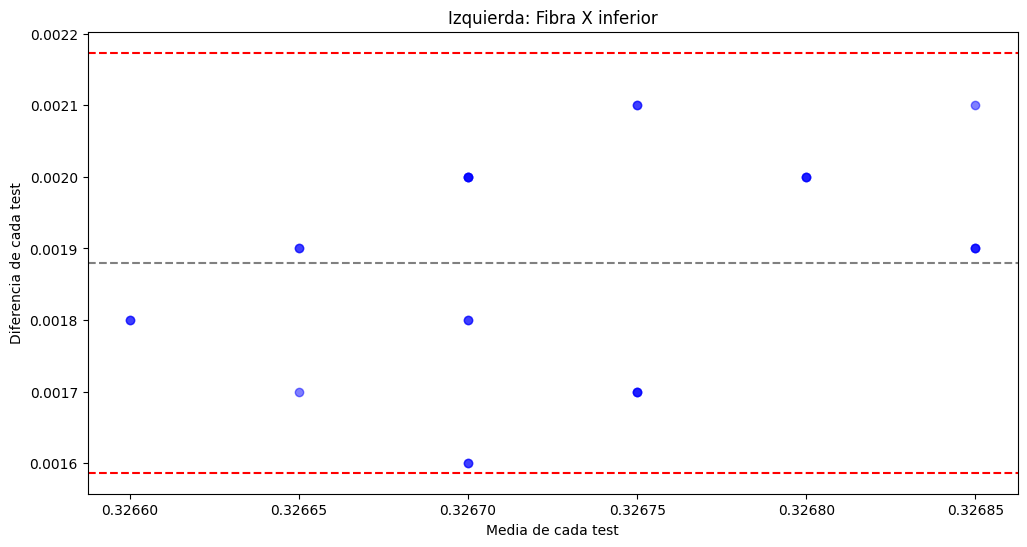

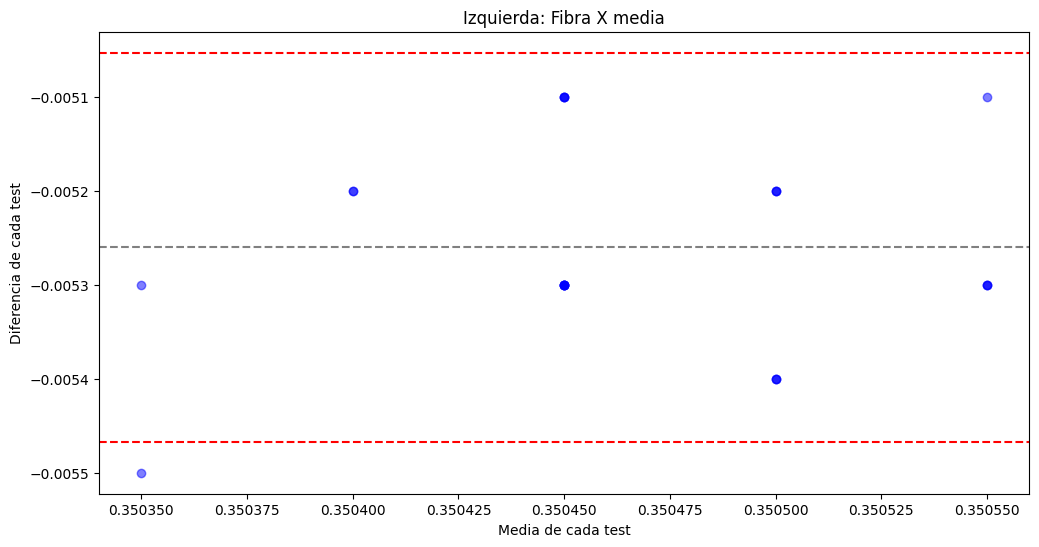

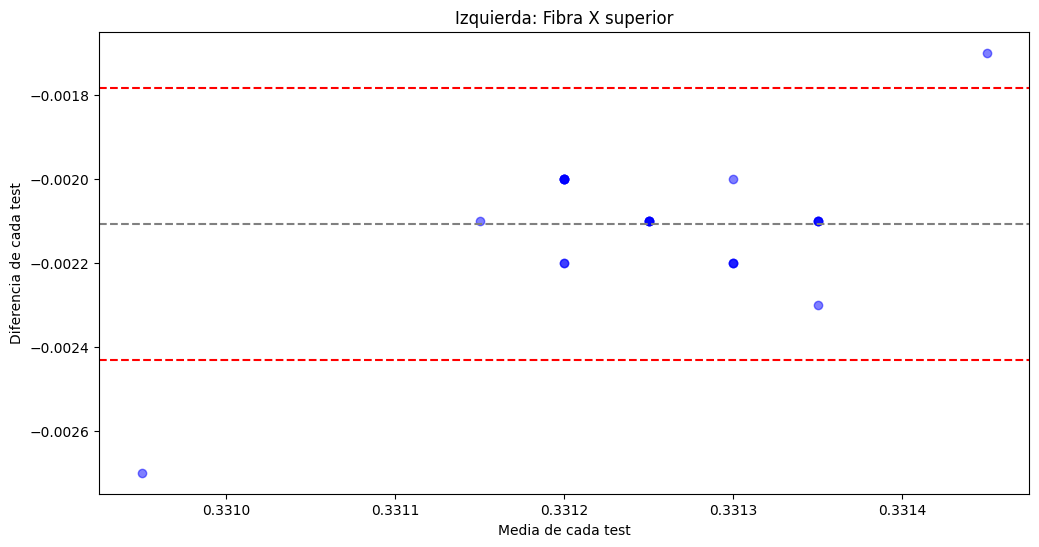

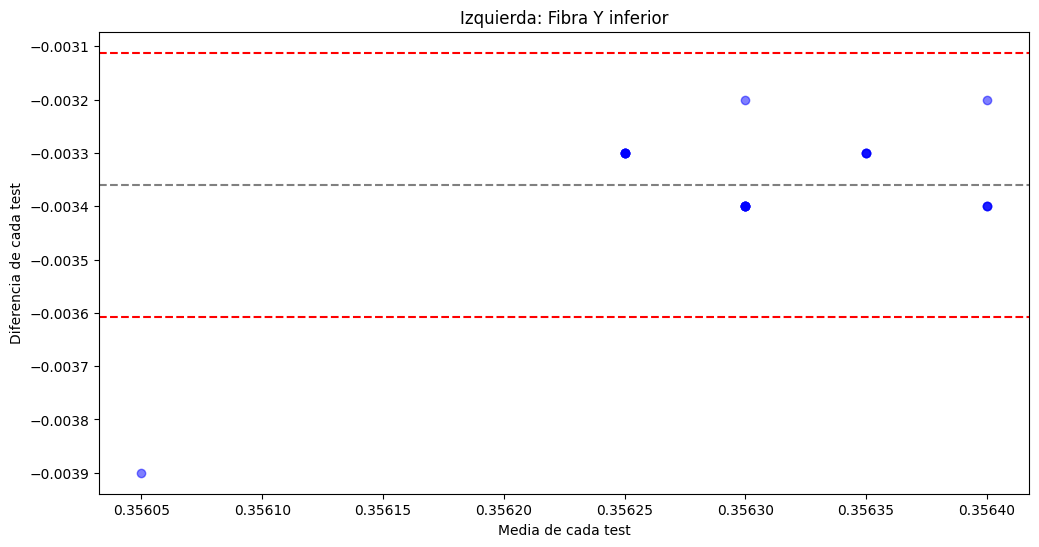

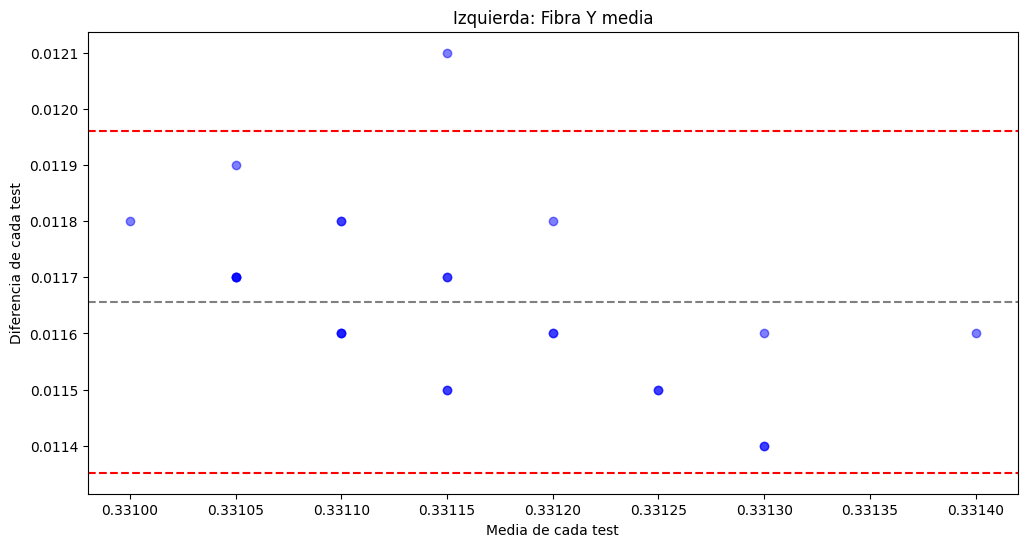

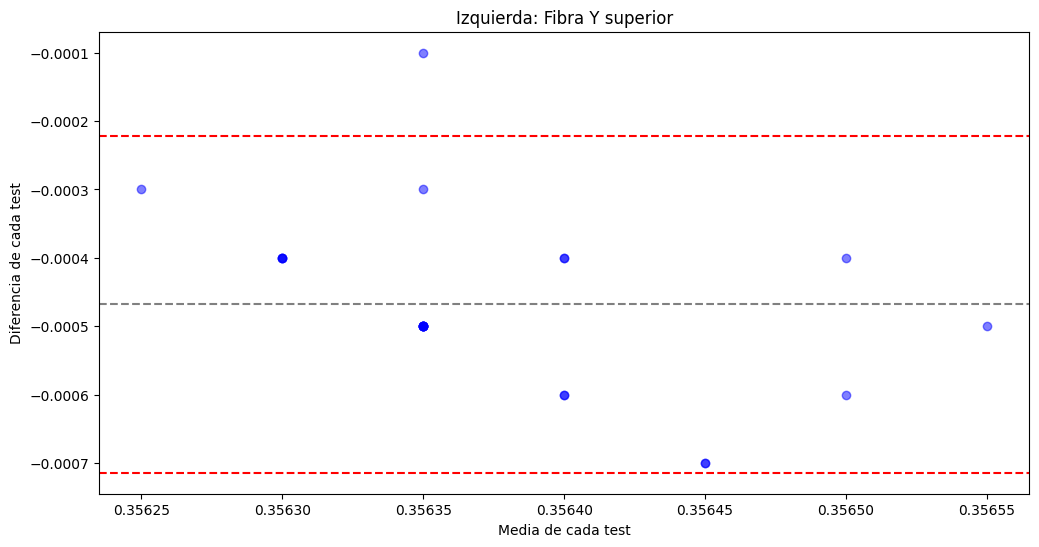

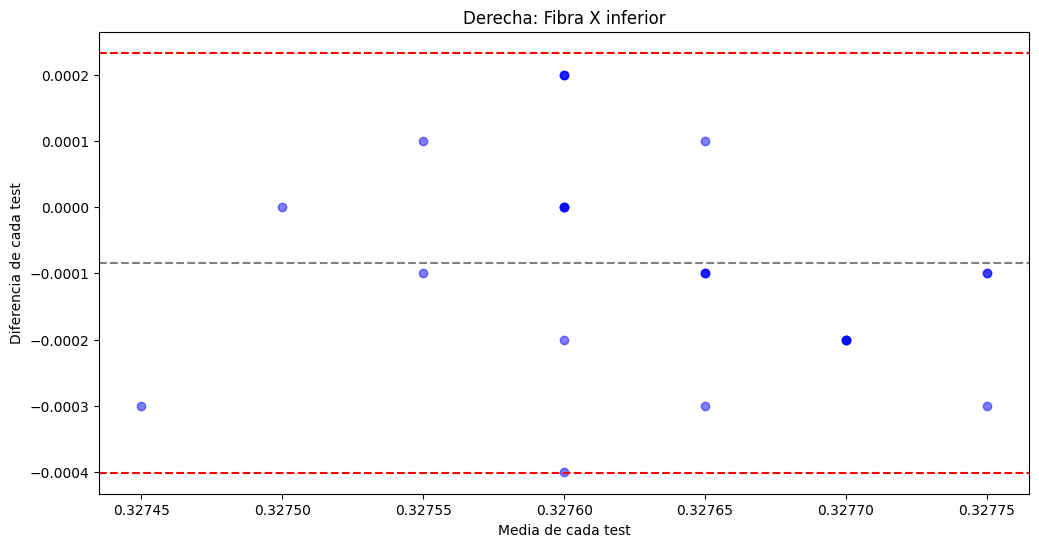

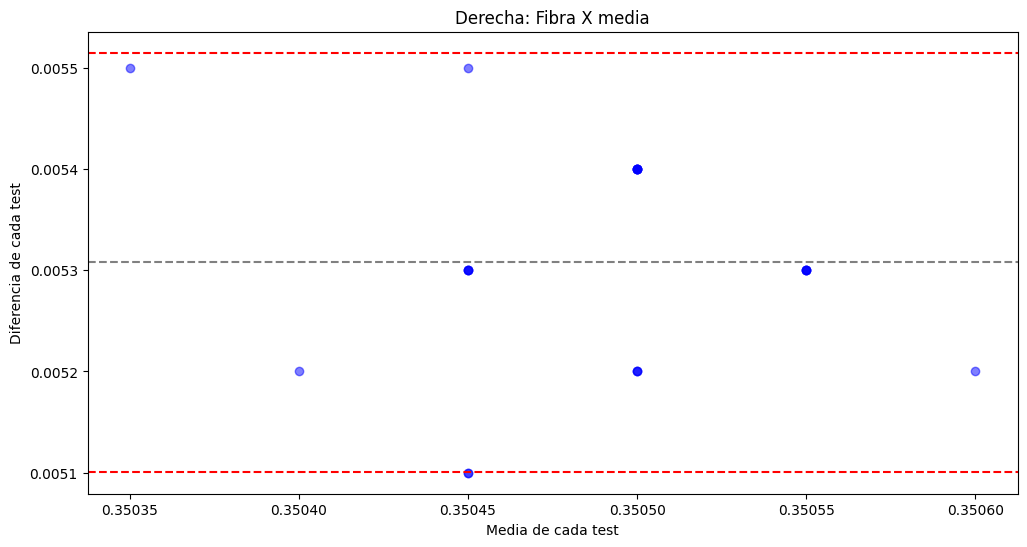

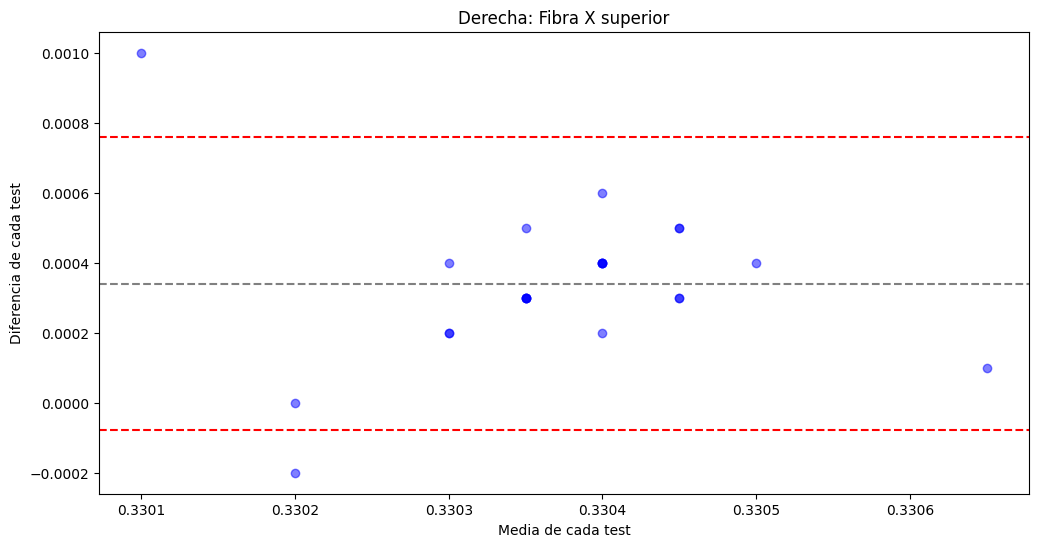

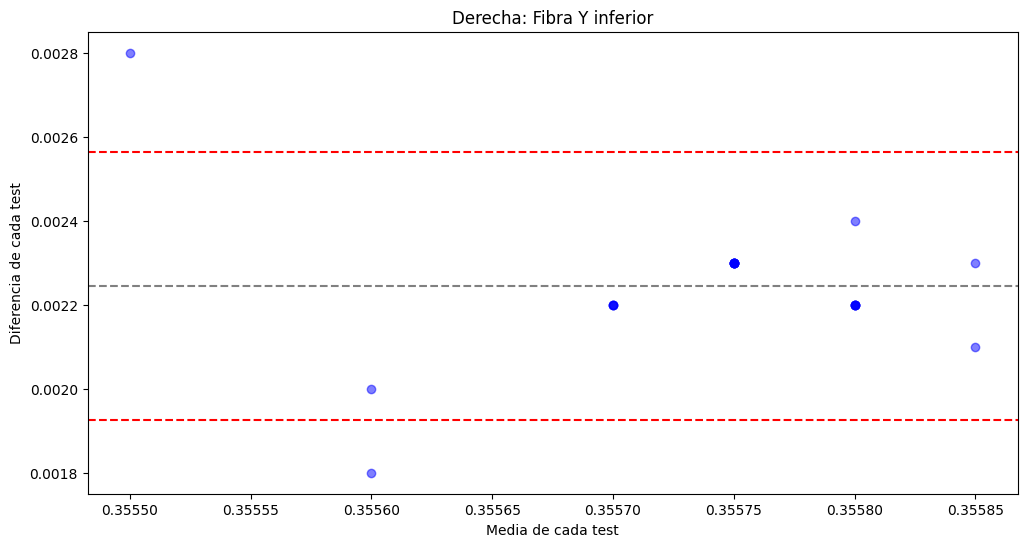

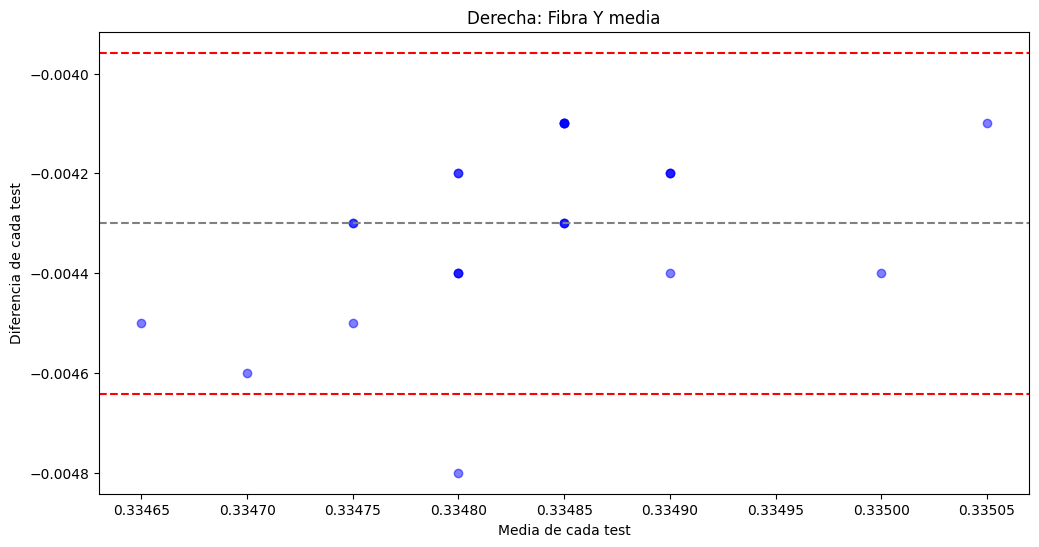

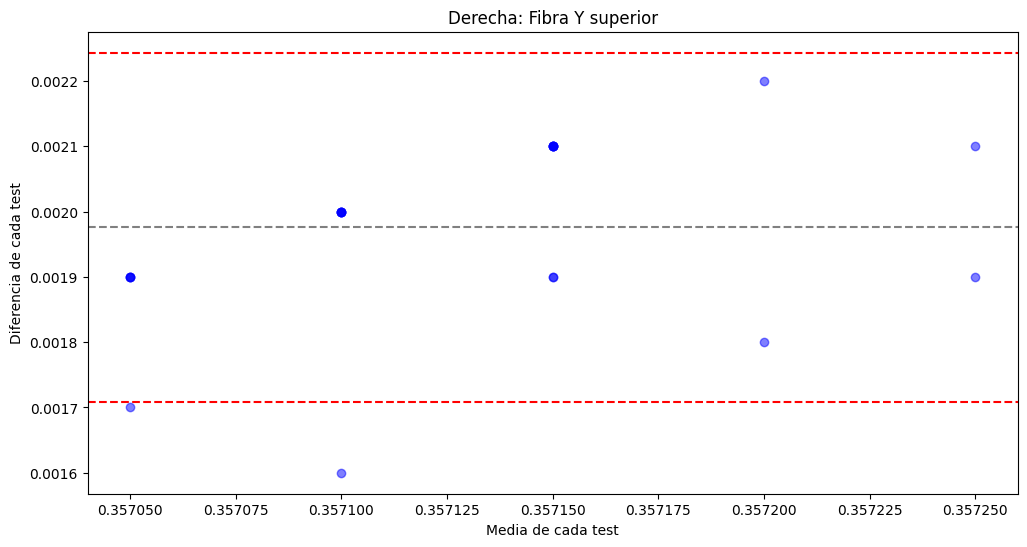

In [20]:
for i in range(int(fibers.shape[0]/2)):
    j = i + 6
    differences = [m2 - m1 for m1, m2 in zip(fibers[i], fibers[j])]
    average = [(m1 + m2) / 2 for m1, m2 in zip(fibers[i], fibers[j])]
    mean_difference = sum(differences) / len(differences)
    sd_difference = (sum((diff - mean_difference) ** 2 for diff in differences) / len(differences)) ** 0.5
    upper_limit = mean_difference + 1.96 * sd_difference
    lower_limit = mean_difference - 1.96 * sd_difference
    plt.subplots(figsize=(12, 6))
    plt.title(titles[i])
    plt.ylabel("Diferencia de cada test")
    plt.xlabel("Media de cada test")
    plt.axhline(y=mean_difference, color='gray', linestyle='--', label='Mean Difference')
    plt.axhline(y=upper_limit, color='red', linestyle='--', label='Upper Limit of Agreement')
    plt.axhline(y=lower_limit, color='red', linestyle='--', label='Lower Limit of Agreement')
    plt.scatter(average, differences, color='blue', alpha=0.5)
    plt.savefig(f'bland-altman{i}.png')
    plt.show()


In [17]:
date = get_date()
name_scatter = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_scatter_" + date + ".pdf"
name_bloxplot = FIXTURE_DATA.loc["Tooling name", "Tooling data"] + "_EDA_boxplot_" + date + ".pdf"
confirmation = input("Do you want to export the data? (y/n): ").strip().lower()
if confirmation == 'y':
    output_filepath = os.path.abspath("../a2_output/reports")
    filepath = output_html([slopes_list, diffs], "test.html")
    print(f'Analysis data and visualizations exported inside:\n{os.path.split(output_filepath)[0]}')
else:
    print("Operation canceled.")

Analysis data and visualizations exported inside:
c:\Users\User\Desktop\Luciano\Python_Eiit_RyR\a2_Analyser\a2_output
